In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/BSNIP'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['Age_cal'].keys()))
print(len(subs))

1244


In [2]:
import numpy as np

task = 'unk'
x = []
y = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['SZP']:
        continue
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    x.append(p)
    y.append(demo['DXGROUP_1'][sub] == 'SZP')
#     y.append(int(demo['Age_cal'][sub]))
#     y.append(demo['sex'][sub] == 'M')
    
x = np.stack(x)
y = np.array(y).astype('int')

print(x.shape)
print(y.shape)
print(y[0:5])

(199, 34716)
(199,)
[1 1 1 1 1]


In [3]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, n_init='auto').fit(x)
ym = km.labels_
print(ym)
print(np.sum(ym == 0), np.sum(ym == 1))

[0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0
 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 1]
69 130


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse(a,b,axis=None):
    return torch.mean((a-b)**2,axis=axis)**0.5

class Basis(nn.Module):
    def __init__(self, dims, rank, nsubs):
        super(Basis, self).__init__()
        self.A = nn.Parameter(torch.randn(dims,264,rank).float().cuda())
        self.w = nn.Parameter(torch.randn(dims,nsubs).float().cuda())
        self.s = nn.Sigmoid()
        
    def compute(self, dim):
        A = self.A[dim]
        A = A@A.T
        A = A/torch.linalg.norm(A)
        a,b = torch.triu_indices(264,264,offset=1)
        return A[a,b]
    
    def recon(self, dim):
        A = self.compute(dim)
        A = torch.einsum('n,a->na', self.w[0], A)
        return A
    
    def to_img(self, dim):
        A = self.compute(dim).detach().cpu()
        a,b = torch.triu_indices(264,264,offset=1)
        AA = torch.zeros(264,264)
        AA[a,b] = A
        AA = AA + AA.T
        return AA.numpy()
    
    def scramble(self, dim):
        with torch.no_grad():
            self.A[dim] *= 0
            self.A[dim] += torch.randn(264,self.A.shape[-1]).float().cuda()
            self.w[dim] *= 0
            self.w[dim] += torch.randn(self.w.shape[-1]).float().cuda()

xtr = torch.from_numpy(x[ym == 0]).float().cuda()

basis = Basis(1,5,xtr.shape[0])
optim = torch.optim.Adam(basis.parameters(), lr=1e-1, weight_decay=0)

nepochs = 2000
pperiod = 100

for i in range(basis.A.shape[0]):

    for epoch in range(nepochs):
        optim.zero_grad()
        xhat = basis.recon(i)
        rloss = rmse(xtr, xhat)
        rloss.backward()
        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs:
            print(f'{epoch} {float(rloss)} ')
        if epoch == 0:
            start_loss = float(rloss)
        if epoch > 0 and epoch % 200 == 0 and float(rloss)/start_loss > 0.995:
            print('Scrambling')
            basis.scramble(i)

print('Complete')



0 0.363518089056015 
100 0.3303493559360504 
200 0.29984453320503235 
300 0.2732301950454712 
400 0.2504526674747467 
500 0.23177790641784668 
600 0.21728982031345367 
700 0.20670625567436218 
800 0.19940932095050812 
900 0.1946154534816742 
1000 0.19157366454601288 
1100 0.18969102203845978 
1200 0.18854185938835144 
1300 0.18784791231155396 
1400 0.18743400275707245 
1500 0.1871856302022934 
1600 0.18703988194465637 
1700 0.1869547963142395 
1800 0.18690626323223114 
1900 0.18687790632247925 
Complete


In [8]:
b0 = basis

In [6]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


NameError: name 'b0' is not defined

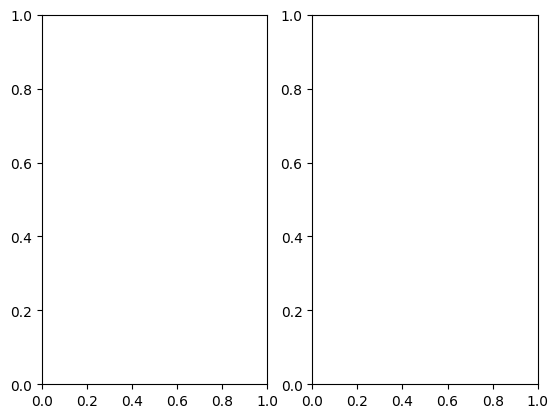

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
im = ax[0].imshow(remap(b0.to_img(0)))
fig.colorbar(im, ax=ax[0])
im = ax[1].imshow(remap(b1.to_img(0)))
fig.colorbar(im, ax=ax[1])
fig.show()